# Figure 1: Influence of downscaling temperature-index model parameteres on the calibration

In [1]:
# path where OGGM gdirs are: is created in data_creating_scripts
working_dir = '/home/users/lschuster/Schuster_et_al_phd_paper_1_cluster/oggm_run_gdir_folder/node_folder'
# figure path
fig_path = '/home/users/lschuster/Schuster_et_al_phd_paper_1_cluster/figures'

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
plt.rc('font', size=20)
import time
import logging
import warnings
warnings.filterwarnings("once", category=DeprecationWarning)  # noqa: E402
from sklearn.metrics import mean_absolute_error
import scipy
import numpy as np
import pandas as pd

# imports from OGGM
import oggm
from oggm import utils, workflow, tasks, cfg, entity_task
import MBsandbox
from MBsandbox.mbmod_daily_oneflowline import (TIModel_Sfc_Type, TIModel, process_w5e5_data)
from MBsandbox.help_func import (minimize_winter_mb_brentq_geod_via_pf, minimize_bias_geodetic,
                                 calibrate_to_geodetic_bias_winter_mb,
                                get_mean_mb_profile_filtered)

log = logging.getLogger(__name__)

base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')
climate_type = 'W5E5'

In [ ]:
# get the geodetic calibration data
pd_geodetic_all = utils.get_geodetic_mb_dataframe()
# pd_geodetic_all = pd.read_hdf(path_geodetic, index_col='rgiid')
pd_geodetic = pd_geodetic_all.loc[pd_geodetic_all.period == '2000-01-01_2020-01-01']


### observed data stuff
# winter MB
_, pathi = utils.get_wgms_files()
pd_mb_overview = pd.read_csv(pathi[:-len('/mbdata')] + '/mb_overview_seasonal_mb_time_periods_20220301.csv',
                             index_col='Unnamed: 0')
pd_wgms_data_stats = pd.read_csv(pathi[:-len('/mbdata')] + '/wgms_data_stats_20220301.csv', index_col='Unnamed: 0')

# should have at least 5 annual MB estimates in the time period 1980-2019
# (otherwise can also not have MB profiles or winter MB!)
pd_wgms_data_stats = pd_wgms_data_stats.loc[pd_wgms_data_stats.len_annual_balance>=5]
ref_candidates = pd_wgms_data_stats.rgi_id.unique()

cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True #True
cfg.PATHS['working_dir'] = working_dir
cfg.PARAMS['hydro_month_nh'] = 1
cfg.PARAMS['hydro_month_sh'] = 1
cfg.PARAMS['continue_on_error'] = True
warnings.filterwarnings("ignore", category=DeprecationWarning) 

gdirs = workflow.init_glacier_directories(['RGI60-11.00897'])

2023-01-13 10:03:51: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2023-01-13 10:03:51: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2023-01-13 10:03:51: oggm.cfg: Multiprocessing: using all available processors (N=32)
2023-01-13 10:03:51: oggm.cfg: Multiprocessing switched ON after user settings.
2023-01-13 10:03:51: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.
2023-01-13 10:03:51: oggm.workflow: Execute entity tasks [GlacierDirectory] on 1 glaciers


### Create data for Figure 1

In [ ]:
# select example glacier 
# -> this could be changed to another glacier that also has the same informations
df = ['RGI60-11.00897']
# three options of the temporal climate resolutio: 'mb_monthly', 'mb_pseudo_daily_fake' , 'mb_real_daily'
mb_type = 'mb_monthly' #'mb_real_daily' #monthly'
# three options of if and how surface type is distinguished: 'no',  'monthly_neg_exp', 'monthly_linear'
sfc_type_distinction = 'no'  #'monthly_neg_exp'
# two options of temperature lapse rate: 'cte', 'var_an_cycle'
grad_type = 'cte'

In [3]:
gdir = gdirs[0]
melt_f = 200
pf = 1.5

# get the geodetic data for calibration
pd_geodetic = oggm.utils.get_geodetic_mb_dataframe()
pd_geodetic = pd_geodetic.loc[pd_geodetic.period == '2000-01-01_2020-01-01']
mb_geodetic = pd_geodetic.loc[df].dmdtda.values * 1000
years = np.arange(2000, 2020, 1)
fls = gdir.read_pickle('inversion_flowlines')
h,w = gdir.get_inversion_flowline_hw()


baseline_climate='W5E5'
if sfc_type_distinction == 'monthly_neg_exp':
    mb_model_sub_class = TIModel_Sfc_Type
    melt_f_update = 'monthly'
    kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp', 'tau_e_fold_yr':1,
                                   'spinup_yrs':6, 'melt_f_update':melt_f_update,
                                    'melt_f_ratio_snow_to_ice':0.5}
elif sfc_type_distinction == 'annual_neg_exp':
    mb_model_sub_class = TIModel_Sfc_Type
    melt_f_update = 'annual'
    kwargs_for_TIModel_Sfc_Type = {'melt_f_change':'neg_exp', 'tau_e_fold_yr':1,
                                   'spinup_yrs':6, 'melt_f_update':melt_f_update,
                                    'melt_f_ratio_snow_to_ice':0.5}
elif sfc_type_distinction == 'no':
    mb_model_sub_class = TIModel
    kwargs_for_TIModel_Sfc_Type = {}
    
    
mb = mb_model_sub_class(gdir, 200, mb_type=mb_type, grad_type = grad_type,
                         prcp_fac=2.5,
                         baseline_climate=baseline_climate, **kwargs_for_TIModel_Sfc_Type)

In [5]:
pd_mb_overview_sel_gdir = pd_mb_overview.loc[pd_mb_overview.rgi_id == gdir.rgi_id]
pd_mb_overview_sel_gdir.index = pd_mb_overview_sel_gdir.Year
yrs_seasonal_mbs = pd_mb_overview_sel_gdir.Year.values
winter_mb_observed_mean = gdir.get_ref_mb_data(input_filesuffix='_monthly_W5E5').loc[yrs_seasonal_mbs]['WINTER_BALANCE'].mean()

winter_mb_observed = gdir.get_ref_mb_data(input_filesuffix='_monthly_W5E5').loc[yrs_seasonal_mbs]['WINTER_BALANCE']

# MB profile
obs_mean_mb_profile_filtered, ys_mb_prof = get_mean_mb_profile_filtered(gdir, input_fs='_monthly_W5E5', obs_ratio_needed=0.6)

# annual MB
mbdf = gdir.get_ref_mb_data(input_filesuffix='_monthly_W5E5')
ys_glac = mbdf.index.values
ref_mb_annual = mbdf['ANNUAL_BALANCE'].loc[ys_glac].values


In [6]:
pf_to_model = np.arange(0.1, 6, 0.1) #[0.1, 0.3, 0.7, 1, 1.5, 2, 2.5, 3, 4, 5]
melt_f_l = []
pf_l = []
winter_mb_mean_l = []
quot_std_l = []
mb_annual_l = []
y_modelled_l = []
mae_l = []
winter_mb_l_temp_b_0 = []
for pf in pf_to_model:
    mb.temp_bias = 0
    melt_f = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                                  xtol=0.01,
                                                  args=(mb, mb_geodetic, h, w, pf),
                                                  disp=True)
    melt_f_l.append(melt_f)
    pf_l.append(pf)
    
    mb.melt_f = melt_f
    mb.prcp_fac = pf #pf_cte = pf_cte
    # first get it in "ascending" order (necessary for sfc type distinction) !
    mb.get_specific_mb(heights=h, widths=w,
                                        year=np.arange(1979,2020,1))
    # winter MB
    winter_mb = mb.get_specific_winter_mb(heights=h, year=yrs_seasonal_mbs, widths=w, 
                                                             add_climate=False,
                                                             period_from_wgms=True)
    # also get the non-averaged winter MB for the plot (although it might not exist for every year ... )
    winter_mb_l_temp_b_0.append(winter_mb)
    winter_mb_mean_l.append(winter_mb.mean())
    
    # direct annual time series:
    mb_annual = mb.get_specific_mb(heights=h, widths=w,
                                    year=ys_glac)
    mb_annual_l.append(mb_annual)
    
    quot_std = mb_annual.std() / ref_mb_annual.std()
    quot_std_l.append(quot_std)
    
    # get modelled MB profiles
    fac = cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density']
    mb_annual = []
    for y in ys_mb_prof:
        #if isinstance(gd_mb, TIModel):
        mb_y = mb.get_annual_mb(h, y)*fac
            #print(h, mb_y)
        #else:
         #   mb_y = gd_mb.pd_mb_annual[y]
        mb_annual.append(mb_y)
    y_modelled = np.array(mb_annual).mean(axis=0)
    y_modelled_l.append(y_modelled)
    
    h_condi = obs_mean_mb_profile_filtered.index
    condi1 = ((h > min(h_condi)) & (h < max(h_condi)))
    f = scipy.interpolate.interp1d(h_condi,
                                   obs_mean_mb_profile_filtered.values,
                                   kind='cubic')
    y_interp_obs = f(h[condi1])
    mae = mean_absolute_error(y_interp_obs, y_modelled[condi1])
    mae_l.append(mae)
    
pd_pf_data = pd.DataFrame(np.array([pf_l, melt_f_l, winter_mb_mean_l, mb_annual_l, quot_std_l, y_modelled_l, mae_l]).T,
             columns = ['pf', 'melt_f', 'winter MB mean', 'MB annual', 'quot_std', 'MB profile', 'mae mb profile'])

/tmp/ipykernel_1123788/2858519317.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pd_pf_data = pd.DataFrame(np.array([pf_l, melt_f_l, winter_mb_mean_l, mb_annual_l, quot_std_l, y_modelled_l, mae_l]).T,


In [7]:
### same for temp. bias sensitivity ...
pf_cte = 2
temp_bias_to_model = np.arange(-5,5.01,0.1)
melt_f_l = []
pf_l = []
winter_mb_mean_l = []
winter_mb_l_pf_2 = []
quot_std_l = []
mb_annual_l = []
temp_bias_l = []
y_modelled_l = []
mae_l = []
for temp_bias in temp_bias_to_model:
    try:
        mb.temp_bias = temp_bias
        melt_f = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                                      xtol=0.01,
                                                      args=(mb, mb_geodetic, h, w, pf_cte),
                                                      disp=True)
        melt_f_l.append(melt_f)
        pf_l.append(pf)
        mb.melt_f = melt_f
        mb.prcp_fac = pf_cte
        # first get it in "ascending" order (necessary for sfc type distinction) !
        mb.get_specific_mb(heights=h, widths=w,
                                        year=np.arange(1979,2020,1))
        # winter MB
        winter_mb = mb.get_specific_winter_mb(heights=h, year=yrs_seasonal_mbs, widths=w, 
                                                                 add_climate=False,
                                                                 period_from_wgms=True)
        winter_mb_mean_l.append(winter_mb.mean())
        # also get the non-averaged winter MB for the plot (although it might not exist for every year ... )
        winter_mb_l_pf_2.append(winter_mb)
        
        # direct annual time series:
        mb_annual = mb.get_specific_mb(heights=h, widths=w,
                                        year=ys_glac)
        mb_annual_l.append(mb_annual)

        quot_std = mb_annual.std() / ref_mb_annual.std()
        quot_std_l.append(quot_std)
        temp_bias_l.append(temp_bias)
        
        # get modelled MB profiles
        fac = cfg.SEC_IN_YEAR * cfg.PARAMS['ice_density']
        mb_annual = []
        for y in ys_mb_prof:
            mb_y = mb.get_annual_mb(h, y)*fac
            mb_annual.append(mb_y)
        y_modelled = np.array(mb_annual).mean(axis=0)
        y_modelled_l.append(y_modelled)

        h_condi = obs_mean_mb_profile_filtered.index
        condi1 = ((h > min(h_condi)) & (h < max(h_condi)))
        f = scipy.interpolate.interp1d(h_condi,
                                       obs_mean_mb_profile_filtered.values,
                                       kind='cubic')
        y_interp_obs = f(h[condi1])
        mae = mean_absolute_error(y_interp_obs, y_modelled[condi1])
        mae_l.append(mae)
    except:
        pass
pd_temp_bias_data = pd.DataFrame(np.array([temp_bias_l, pf_l, melt_f_l, winter_mb_mean_l, mb_annual_l, quot_std_l, y_modelled_l, mae_l]).T,
             columns = ['temp_bias', 'pf', 'melt_f', 'winter MB mean', 'MB annual', 'quot_std','MB profile', 'mae mb profile'])


/tmp/ipykernel_1123788/3177290713.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pd_temp_bias_data = pd.DataFrame(np.array([temp_bias_l, pf_l, melt_f_l, winter_mb_mean_l, mb_annual_l, quot_std_l, y_modelled_l, mae_l]).T,


### Make Fig. 1: 

In [8]:

#normalize item number values to colormap
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5.01)
fac_per_month_to_per_day = 365.25/12

num_dict = {0:'(a)', 1:'(b)', 2:'(c)', 3:'(d)', 4: '(e)', 5:'(f)', 6:'(g)', 7:'(h)', 8:'(i)', 9:'(j)', 10:'(k)', 11:'(l)', 12:'(m)'} 
len(winter_mb_l_temp_b_0)

59

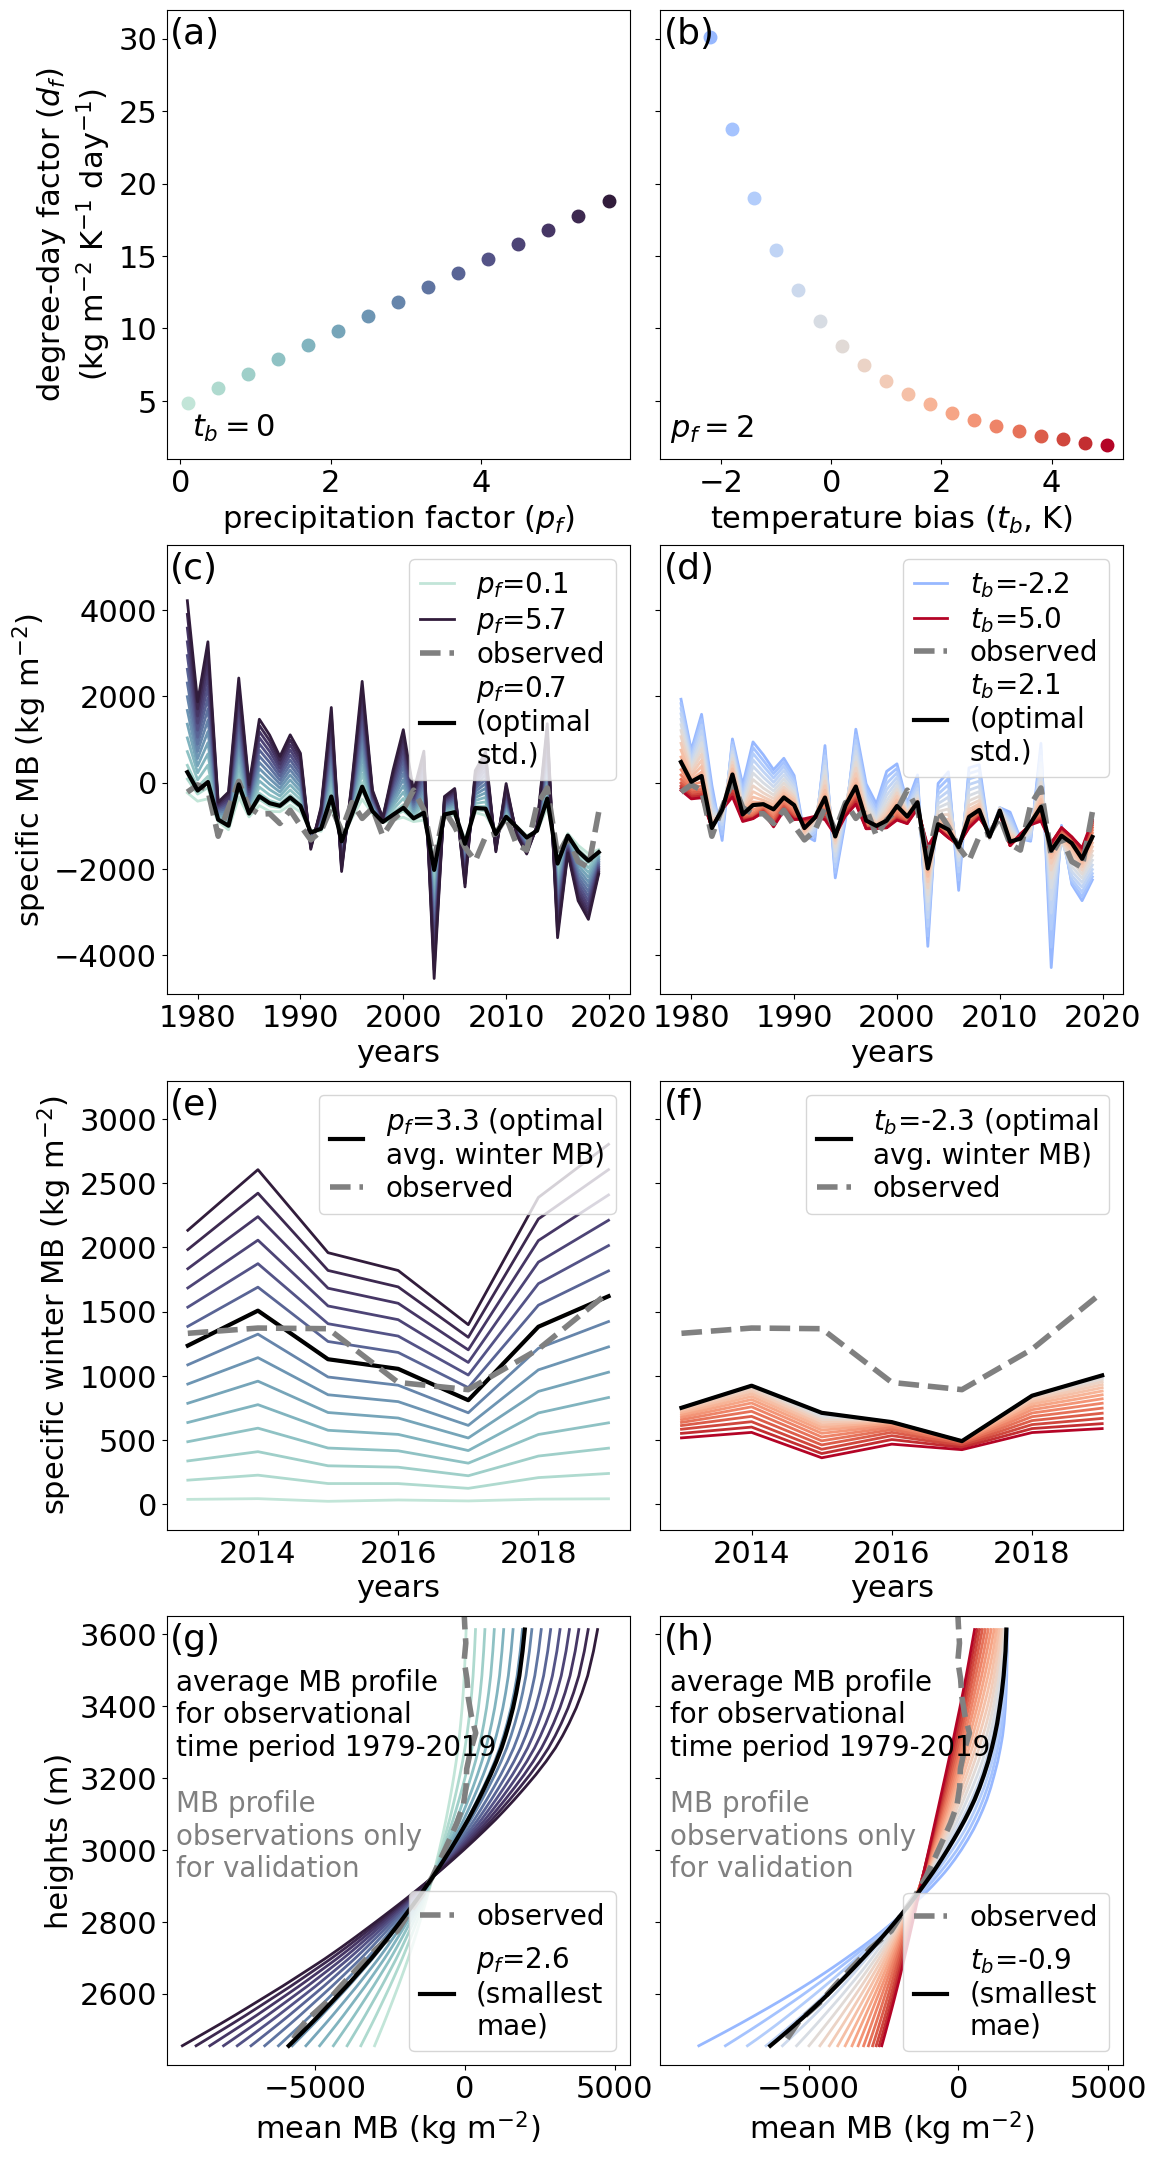

In [10]:
plt.rc('font', size=22)

num_text_x = 0.007
num_text_y = 0.925

c= 4
r = 2
ms = 18 #14
ms_x = 11
param = pf
param_to_model = pf_to_model
f = 1
k = 1
pf_to_model_p = pf_to_model[::4]
pf_to_model_pp = pf_to_model[::4]

import seaborn as sns
col_pf = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=len(pf_to_model_p))
col_pf_pp = sns.cubehelix_palette(start=.5, rot=-.5, n_colors=len(pf_to_model_pp))

plt.figure(figsize=(12, 22))
pd_data = pd_pf_data


n=1
plt.subplot(c, r, n)
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=26, transform=plt.gca().transAxes)

for j,pf in enumerate(pf_to_model_p):
    plt.plot(pf, pd_data.loc[pd_data.pf == pf, 'melt_f']/fac_per_month_to_per_day, '.', color=col_pf[j], ms=ms)

    
#slope, intercept,rval, pval, std_err= scipy.stats.linregress(pd_data['pf'].astype(float).values,
#                                                             pd_data['melt_f'].astype(float).values/fac_per_month_to_per_day)
#plt.plot(pd_data.pf.astype(float), slope*pd_data.pf.astype(float) + intercept, ':',
#         color = 'grey',
#         label = 'linear fit:\n'+f'R$^2$={rval:.4f}'+ '\n' +f'std. error={std_err:.2f}') #, pval={pval:.0e}'
#plt.legend(loc='lower right')
plt.ylabel(r'degree-day factor ($d_f$)'+'\n'+r'(kg m$^{-2}$ K$^{-1}$ day$^{-1}$)')
plt.xlabel(r'precipitation factor ($p_f$)')
plt.text(0.055,0.05, r'$t_b=0$', transform=plt.gca().transAxes)
ax_pf_melt_f = plt.gca()
ax_pf_melt_f.set_ylim([1,32])


n=5
plt.subplot(c, r, n) ###, sharex= ax_pf_melt_f) #9


pd_data['abs_bias_winter_mb'] = np.abs(pd_data['winter MB mean']- winter_mb_observed_mean)
pf_opt_winter_mb = pd_data.iloc[np.argmin(pd_data['abs_bias_winter_mb'])].pf


pd_data['quot_std_abs_min_1'] = np.abs(pd_data['quot_std']-1)
pf_opt_std = pd_data.iloc[np.argmin(pd_data['quot_std_abs_min_1'])].pf

pf_opt_mae = pd_data.iloc[np.argmin(pd_data['mae mb profile'])].pf


plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=26, transform=plt.gca().transAxes)
for j,pf in enumerate(pf_to_model_pp):
    j_real = pd_pf_data.loc[pd_pf_data.pf==pf].index[0]
    plt.plot(yrs_seasonal_mbs, winter_mb_l_temp_b_0[j_real],
             color = col_pf_pp[j], ms=ms, label = r'$p_f$='+f'{pf:.1f}',lw=2)
plt.plot(yrs_seasonal_mbs, winter_mb_l_temp_b_0[pd_pf_data.loc[pd_pf_data.pf==pf_opt_winter_mb].index[0]], ms=ms,
         label = r'$p_f$='+f'{pf_opt_winter_mb:.1f} (optimal\navg. winter MB)',lw=3, color ='black')
plt.plot(yrs_seasonal_mbs, winter_mb_observed, color = 'grey', lw=4, ls = '--', label='observed')


plt.ylabel('specific winter MB (kg m$^{-2}$)')
plt.xlabel('years')


ax_pf_winter_mb = plt.gca()
handles, labels = ax_pf_winter_mb.get_legend_handles_labels()
leg_list = [#0, #int(len(pf_to_model)/2), 
            #len(pf_to_model_pp)-1,
            len(pf_to_model_pp),len(pf_to_model_pp)+1]
plt.rcParams.update({'legend.fontsize': 20, 'legend.handlelength': 1.2})
ax_pf_winter_mb.legend(handles = [handles[index] for index in leg_list],
                       labels = [labels[index] for index in leg_list], 
                       ncol=1, labelspacing = 0.16, loc='upper right') #, prop={'size': 18, 'handlelength': 2})
ax_pf_winter_mb.set_ylim([-200, 3300])


n=3
plt.subplot(c,r,n)
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=26, transform=plt.gca().transAxes)
for j,pf in enumerate(pf_to_model_p):
    plt.plot(ys_glac, pd_data.loc[pd_data.pf==pf, 'MB annual'].values[0], color = col_pf[j], ms=ms,
             label = r'$p_f$='+f'{pf:.1f}',lw=2)
plt.plot(ys_glac, ref_mb_annual, color = 'grey', lw=4, ls = '--', label='observed')
plt.plot(ys_glac, pd_data.loc[pd_data.pf==pf_opt_std, 'MB annual'].values[0], color = 'black', ms=ms,
         label = r'$p_f$='+f'{pf_opt_std:.1f}\n(optimal\nstd.)',lw=3)

plt.ylabel('specific MB (kg m$^{-2}$)')
plt.xlabel('years')
ax_pf_mb_annual = plt.gca()
handles, labels = ax_pf_mb_annual.get_legend_handles_labels()
leg_list = [0,  
            len(pf_to_model_p)-1,
            len(pf_to_model_p),len(pf_to_model_p)+1]
plt.rcParams.update({'legend.fontsize': 20, 'legend.handlelength': 1.2})
ax_pf_mb_annual.legend(handles = [handles[index] for index in leg_list],
                       labels = [labels[index] for index in leg_list], 
                       ncol=1, labelspacing = 0.16) #, prop={'size': 18, 'handlelength': 2})
ax_pf_mb_annual.set_ylim([-4900, 5500])
ax_pf_mb_annual.set_xlim([1977,2022])

n=7
plt.subplot(c,r,n) #3
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=26, transform=plt.gca().transAxes)
for j,pf in enumerate(pf_to_model_p):
    plt.plot(pd_data.loc[pd_data.pf==pf, 'MB profile'].values[0],
             h, color= col_pf[j],lw=2)
plt.plot(obs_mean_mb_profile_filtered.values,
         obs_mean_mb_profile_filtered.index, '--', color='grey', lw=4, label = 'observed')
plt.plot(pd_data.loc[pd_data.pf==pf_opt_mae, 'MB profile'].values[0],
             h, color= 'black', label = r'$p_f$='+f'{pf_opt_mae:.1f}\n(smallest\nmae)',lw=3)
plt.legend(loc = 'lower right')

plt.gca().text(0.02,0.69, 'average MB profile\nfor observational\ntime period 1979-2019', fontsize=20, transform=plt.gca().transAxes, color = 'black')
plt.gca().text(0.02,0.42, 'MB profile\nobservations only\nfor validation', fontsize=20, transform=plt.gca().transAxes, color = 'grey')
plt.xlabel('mean MB (kg m$^{-2}$)')
plt.ylabel('heights (m)')
ax_pf_mb_prof = plt.gca()
ax_pf_mb_prof.set_xlim([-9950,5500])
ax_pf_mb_prof.set_ylim([2401,3650])
ax_pf_mb_prof.set_xticks([-5000,0,5000])


temp_bias_to_model_p = temp_bias_to_model[::4]
temp_bias_to_model_pp = temp_bias_to_model[::4]

pd_data = pd_temp_bias_data
k = 6
n=2
plt.subplot(c,r,n) 
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=26, transform=plt.gca().transAxes)
for temp_bias in temp_bias_to_model_p:
    try:
        plt.plot(temp_bias, pd_data.loc[pd_data.temp_bias==temp_bias, 'melt_f']/fac_per_month_to_per_day, '.',
             color = cm.coolwarm(norm(temp_bias)), ms=ms)
    except:
        pass
plt.xlim([-3.1,5.3])
ax_temp_bias_melt_f = plt.gca()
plt.xlabel(r'temperature bias ($t_b$, K)')
plt.text(0.02,0.05, r'$p_f=2$', transform=plt.gca().transAxes)
plt.gca().set_yticklabels('')
plt.gca().set_ylim(ax_pf_melt_f.get_ylim())

n=6
pd_data['abs_bias_winter_mb'] = np.abs(pd_data['winter MB mean']- winter_mb_observed_mean)
temp_b_opt_winter_mb = pd_data.iloc[np.argmin(pd_data['abs_bias_winter_mb'])].temp_bias

plt.subplot(c,r,n, sharex=ax_pf_winter_mb) #10
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=26, transform=plt.gca().transAxes)
counti=0
for j,temp_b in enumerate(temp_bias_to_model_pp):
    try:
        j_real = pd_temp_bias_data.loc[np.abs(pd_temp_bias_data.temp_bias.astype(float) - temp_b)<0.001].index[0]
        plt.plot(yrs_seasonal_mbs, winter_mb_l_pf_2[j_real],
                 color = cm.coolwarm(norm(temp_b)), ms=ms, label = r'$t_b$='+f'{temp_b:.1f}',lw=2)
        counti+=1
    except:
        pass
condi = np.abs(pd_temp_bias_data.temp_bias-temp_b_opt_winter_mb)<0.0001
plt.plot(yrs_seasonal_mbs, winter_mb_l_pf_2[pd_temp_bias_data.loc[condi].index[0]],
         ms=ms, label = r'$t_b$='+f'{temp_b_opt_winter_mb:.1f} (optimal\navg. winter MB)',lw=3, color ='black')
plt.plot(yrs_seasonal_mbs, winter_mb_observed, color = 'grey', lw=4, ls = '--', label='observed')

plt.ylabel('') #
plt.xlabel('years')
plt.gca().set_ylim(ax_pf_winter_mb.get_ylim())
plt.gca().set_yticklabels('')

ax_pf_winter_mb2 = plt.gca()
handles, labels = ax_pf_winter_mb2.get_legend_handles_labels()
leg_list = [counti,counti+1]
plt.rcParams.update({'legend.fontsize': 20, 'legend.handlelength': 1.2})
ax_pf_winter_mb2.legend(handles = [handles[index] for index in leg_list],
                       labels = [labels[index] for index in leg_list], 
                       ncol=1, labelspacing = 0.16, loc='upper right') 
pd_data['quot_std_abs_min_1'] = np.abs(pd_data['quot_std']-1)
temp_b_opt_std = pd_data.iloc[np.argmin(pd_data['quot_std_abs_min_1'])].temp_bias

temp_b_opt_mae = pd_data.iloc[np.argmin(pd_data['mae mb profile'])].temp_bias

n=4
plt.subplot(c,r,n, sharex=ax_pf_mb_annual) #2
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=26, transform=plt.gca().transAxes)
temp_bias_working = []
for temp_bias in temp_bias_to_model_p:
    try:
        plt.plot(ys_glac, pd_data.loc[pd_data.temp_bias==temp_bias, 'MB annual'].values[0],
                 color = cm.coolwarm(norm(temp_bias)), ms=ms, label= r'$t_b$='+f'{temp_bias:.1f}', lw=2)
        temp_bias_working.append(temp_bias)
    except:
        pass
plt.plot(ys_glac, ref_mb_annual, color = 'grey', lw=4, ls = '--', label='observed')
plt.plot(ys_glac, pd_data.loc[pd_data.temp_bias==temp_b_opt_std, 'MB annual'].values[0],
         color = 'black', ms=ms, label = r'$t_b$='+f'{temp_b_opt_std:.1f}\n(optimal\nstd.)',lw=3)
plt.xlabel('years')
handles, labels = plt.gca().get_legend_handles_labels()
leg_list = [0, len(temp_bias_working)-1, 
            len(temp_bias_working), len(temp_bias_working)+1]
plt.legend(handles = [handles[index] for index in leg_list],
                       labels = [labels[index] for index in leg_list],
           ncol=1, labelspacing = 0.16) #, prop={'size': 18, 'handlelength': 2})
plt.gca().set_ylim(ax_pf_mb_annual.get_ylim())
plt.gca().set_yticklabels('')

n=8
plt.subplot(c,r,n, sharex=ax_pf_mb_prof)
plt.gca().text(num_text_x,num_text_y, num_dict[n-1], fontsize=26, transform=plt.gca().transAxes)
for temp_bias in temp_bias_to_model_p:
    try:
        plt.plot(pd_data.loc[pd_data.temp_bias==temp_bias, 'MB profile'].values[0],
             h, color= cm.coolwarm(norm(temp_bias)), lw=2)
    except:
        pass
plt.plot(obs_mean_mb_profile_filtered.values,
         obs_mean_mb_profile_filtered.index, '--', color='grey', lw=4, label = 'observed')
plt.plot(pd_data.loc[pd_data.temp_bias==temp_b_opt_mae, 'MB profile'].values[0],
             h, color= 'black', label = r'$t_b$='+f'{temp_b_opt_mae:.1f}\n(smallest\nmae)',lw=3)
plt.legend(loc = 'lower right')
plt.xlabel('mean MB (kg m$^{-2}$)')
plt.gca().set_ylim(ax_pf_mb_prof.get_ylim())

plt.gca().set_yticklabels('')

plt.gca().text(0.02,0.69, 'average MB profile\nfor observational\ntime period 1979-2019',
               fontsize=20, transform=plt.gca().transAxes, color = 'black')
plt.gca().text(0.02,0.42, 'MB profile\nobservations only\nfor validation',
               fontsize=20, transform=plt.gca().transAxes, color = 'grey')
plt.tight_layout(pad=1.01, w_pad=0.01, h_pad= 0.3)

plt.savefig(f'{fig_path}/fig_1_conceptual_parameter_sensitivity_figure_sfc_type_{sfc_type_distinction}_{mb_type}.pdf')